In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score as f1
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
!pip install -q optuna

In [3]:
df = pd.read_csv('/kaggle/input/exam-1/data.csv')
df.head()

,Unnamed: 0,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,...,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay,doctorid,country_code
0,0,1,8,c,3,Z,3,radiotherapy,R,F,...,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10,NaN,1
1,1,2,2,c,5,Z,2,radiotherapy,S,F,...,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50,NaN,1
2,2,3,10,e,1,X,2,anesthesia,S,E,...,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40,NaN,1
3,3,4,26,b,2,Y,2,radiotherapy,R,D,...,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50,NaN,1
4,4,5,26,b,2,Y,2,radiotherapy,S,D,...,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50,NaN,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         318438 non-null  int64  
 1   case_id                            318438 non-null  int64  
 2   Hospital_code                      318438 non-null  int64  
 3   Hospital_type_code                 318438 non-null  object 
 4   City_Code_Hospital                 318438 non-null  int64  
 5   Hospital_region_code               318438 non-null  object 
 6   Available Extra Rooms in Hospital  318438 non-null  int64  
 7   Department                         318438 non-null  object 
 8   Ward_Type                          318438 non-null  object 
 9   Ward_Facility_Code                 318438 non-null  object 
 10  Bed Grade                          318325 non-null  float64
 11  patientid                          3184

In [5]:
df.nunique()

Unnamed: 0                           318438
case_id                              318438
Hospital_code                            32
Hospital_type_code                        7
City_Code_Hospital                       11
Hospital_region_code                      3
Available Extra Rooms in Hospital        18
Department                                5
Ward_Type                                 6
Ward_Facility_Code                        6
Bed Grade                                 4
patientid                             92017
City_Code_Patient                        37
Type of Admission                         3
Severity of Illness                       3
Visitors with Patient                    28
Age                                      10
Admission_Deposit                      7300
Stay                                     11
doctorid                                 12
country_code                              1
dtype: int64

In [6]:
pivot_tables = {}

for column in df.select_dtypes(include=['object','category']).columns:
    pivot_tables[column] = df.groupby(column).size()

for column, table in pivot_tables.items():
    print(f"\n{table}")


Hospital_type_code
a    143425
b     68946
c     45928
d     20389
e     24770
f     10703
g      4277
dtype: int64

Hospital_region_code
X    133336
Y    122428
Z     62674
dtype: int64

Department
TB & Chest disease      9586
anesthesia             29649
gynecology            249486
radiotherapy           28516
surgery                 1201
dtype: int64

Ward_Type
P      5046
Q    106165
R    127947
S     77794
T      1477
U         9
dtype: int64

Ward_Facility_Code
A     27906
B     35156
C     35463
D     51809
E     55351
F    112753
dtype: int64

Type of Admission
Emergency    117676
Trauma       152261
Urgent        48501
dtype: int64

Severity of Illness
Extreme      56723
Minor        85872
Moderate    175843
dtype: int64

Age
0-10       6254
11-20     16768
21-30     40843
31-40     63639
41-50     63749
51-60     48514
61-70     33687
71-80     35792
81-90      7890
91-100     1302
dtype: int64

Stay
0-10                  23604
11-20                 78139
21-30             

In [7]:
df = df.loc[df['Ward_Type'] != 'U']

In [8]:
df.drop(columns=['Unnamed: 0', 'case_id','country_code','doctorid'], inplace = True)

In [9]:
patients = df.groupby('patientid')['patientid'].count()
patients.value_counts()

patientid
1     20348
2     18535
3     15658
4     12335
5      9267
6      6291
7      4054
8      2341
9      1396
10      761
11      400
12      274
13      110
14       74
15       56
16       26
17       24
18       17
20        8
19        7
21        5
22        5
23        4
26        3
30        2
25        2
24        2
27        2
31        1
28        1
34        1
32        1
39        1
50        1
43        1
36        1
29        1
Name: count, dtype: int64

In [10]:
patient_counts = df['patientid'].value_counts()
df['number_of_visits'] = df['patientid'].map(patient_counts)

In [11]:
df = df[df['number_of_visits'] < 20]

In [12]:
bins = [0, 5, 10, 15, float('inf')]
labels = ['0-5', '6-10', '11-15', '16+']
df['visit_group'] = pd.cut(df['number_of_visits'], bins=bins, labels=labels, include_lowest=True)

In [13]:
df.drop(columns=['number_of_visits', 'patientid'], inplace = True)

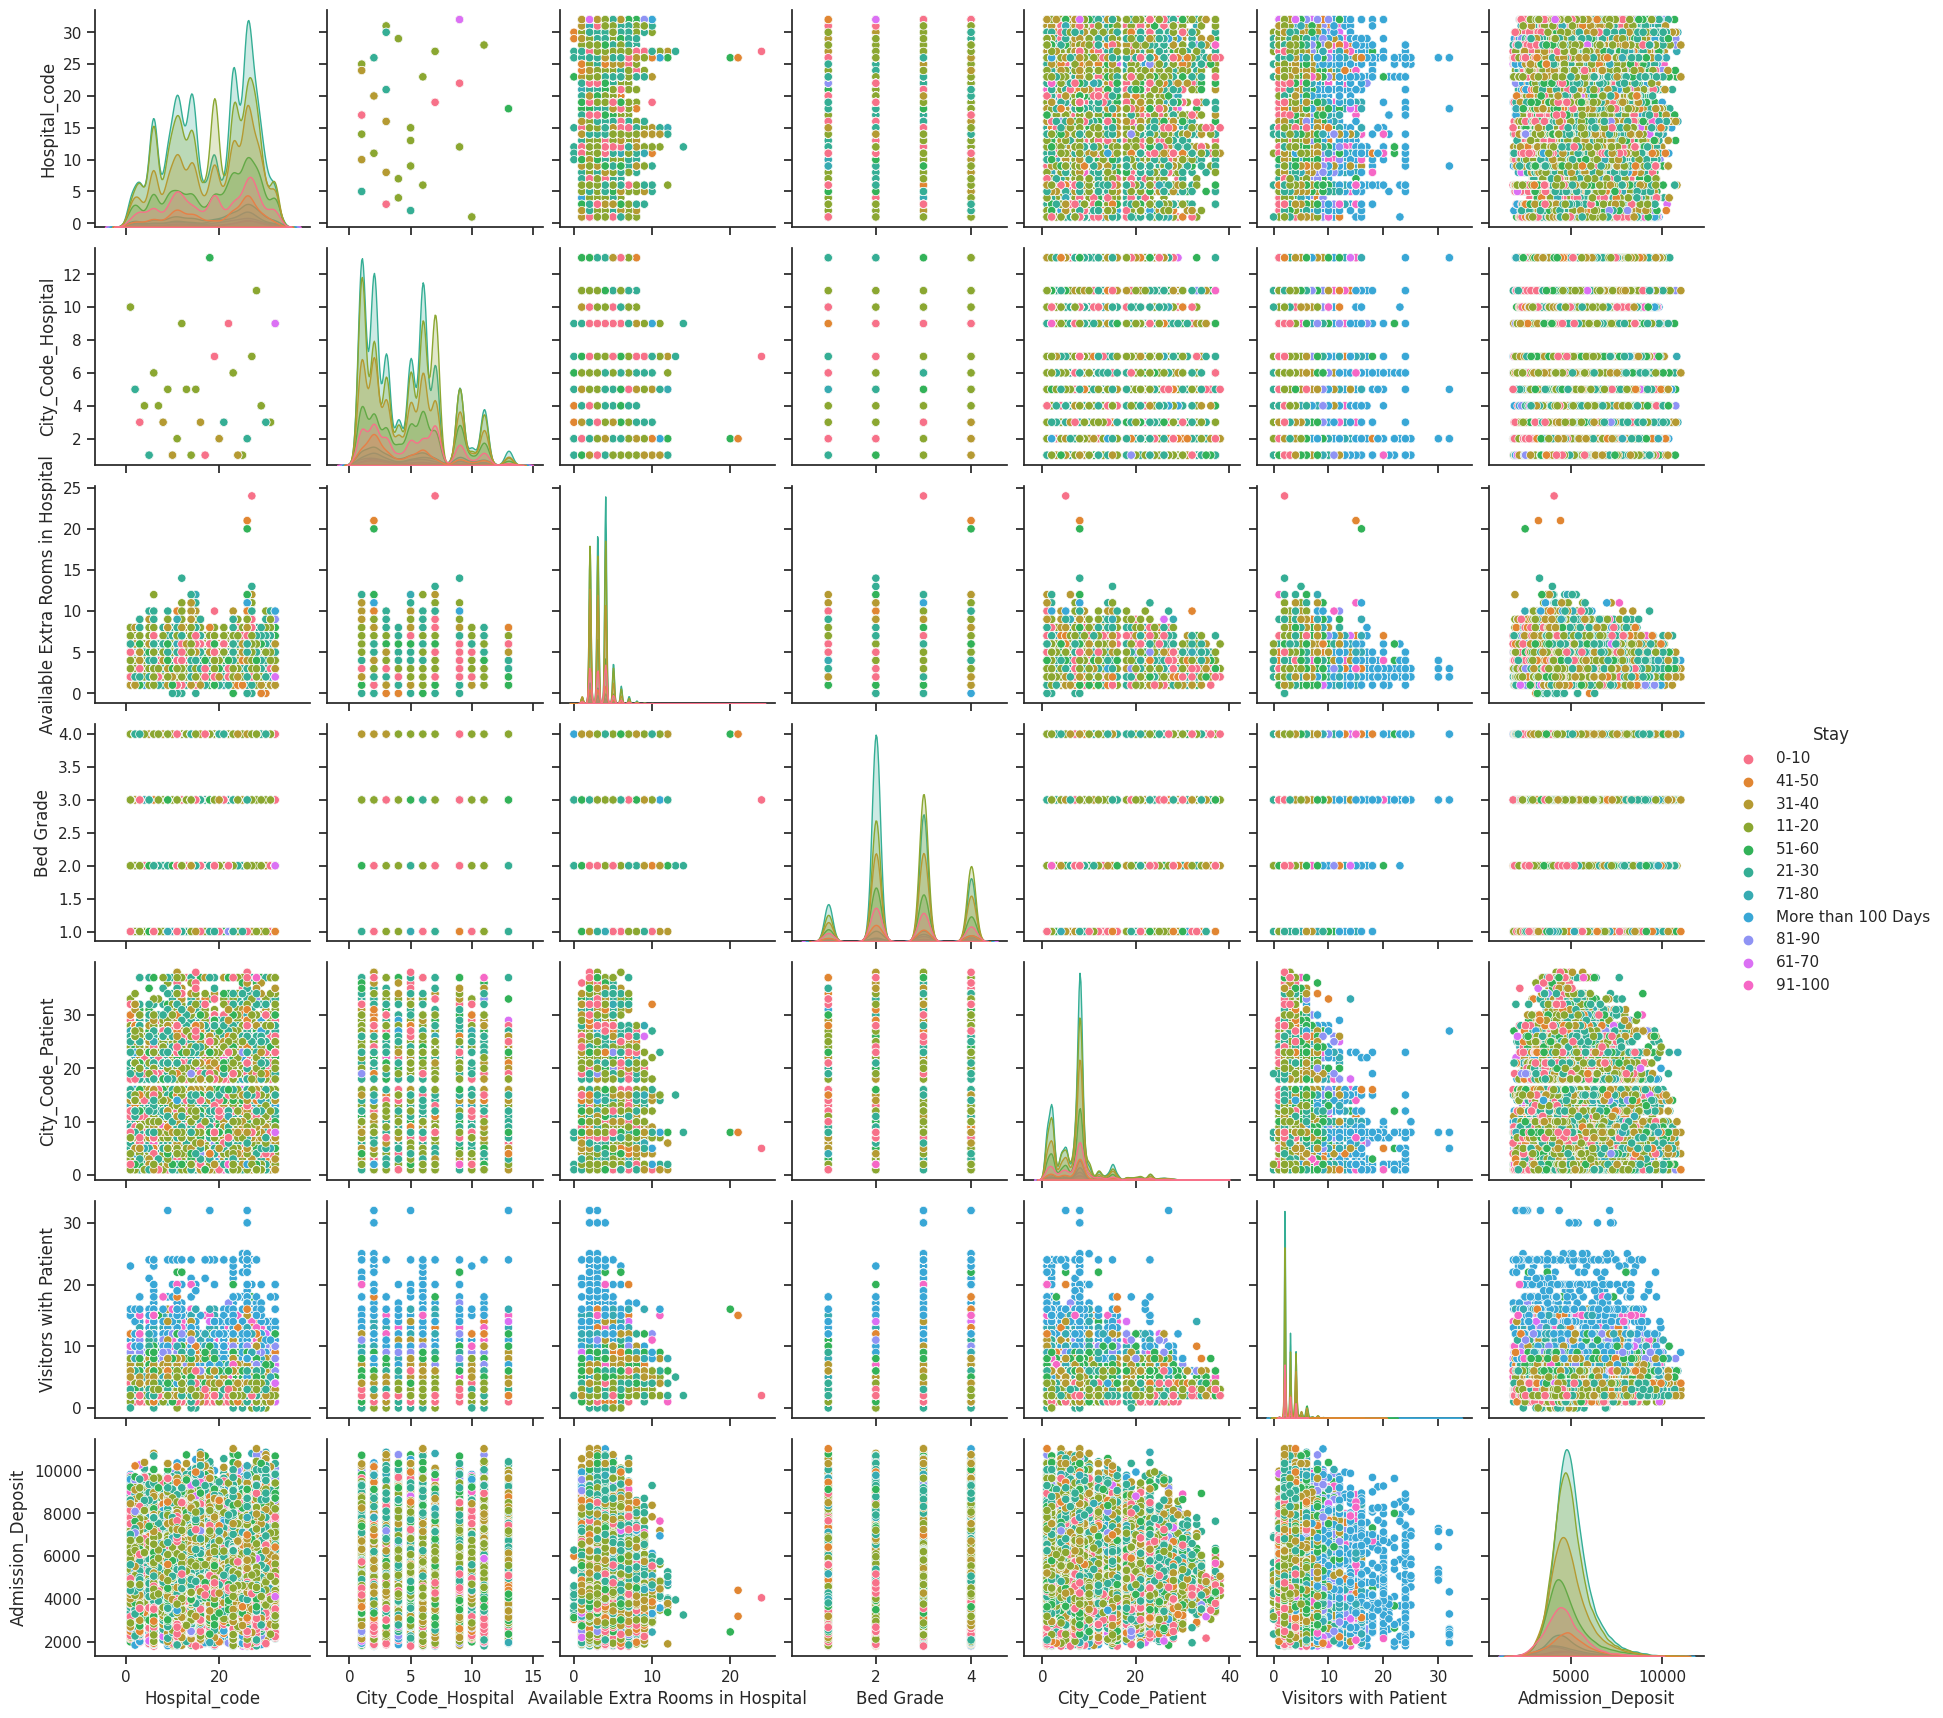

In [14]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Stay")

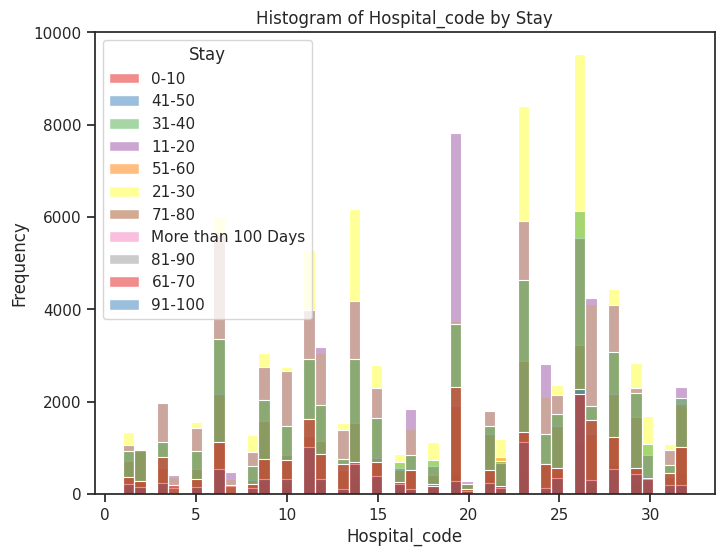

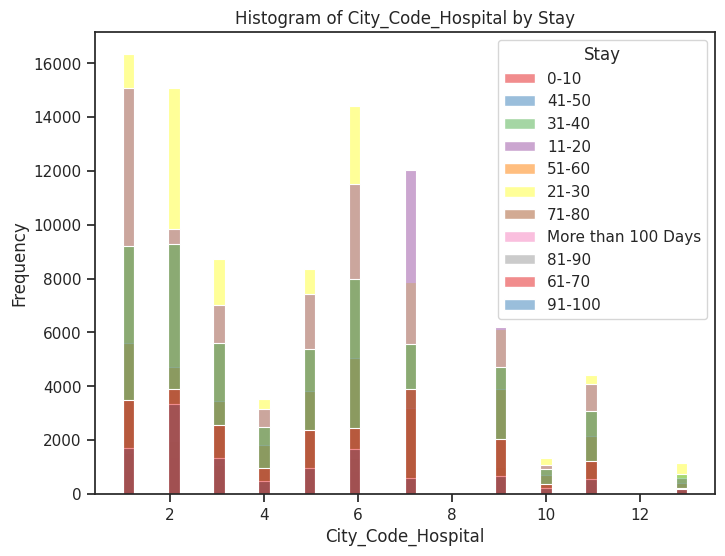

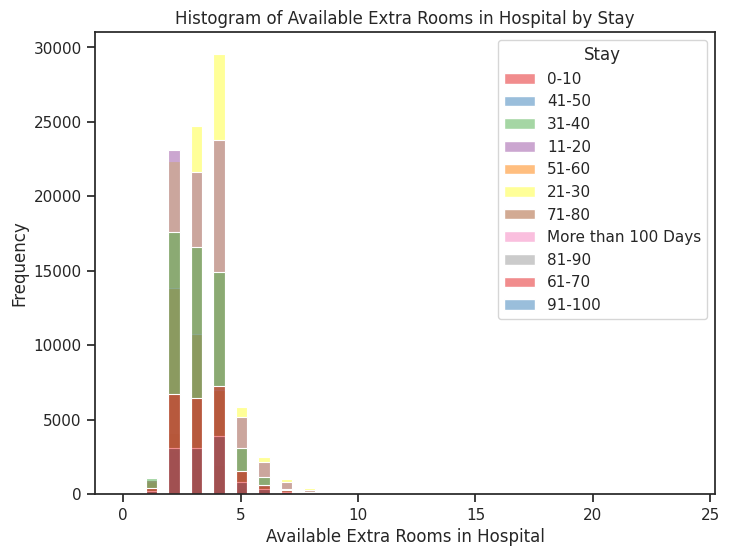

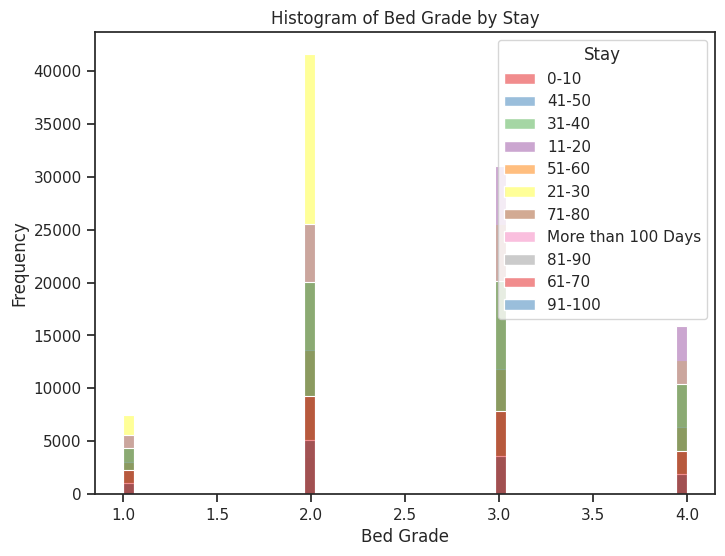

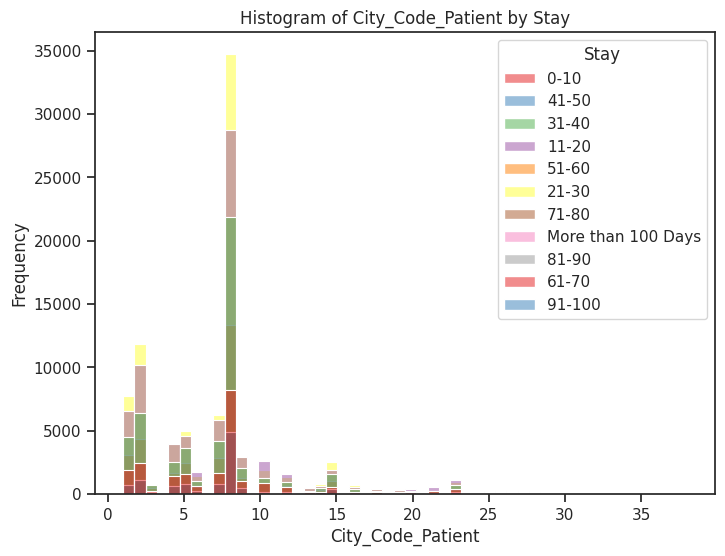

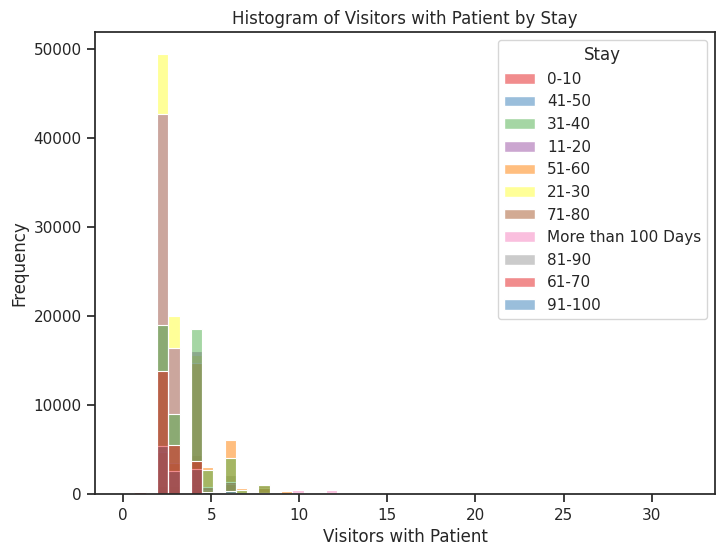

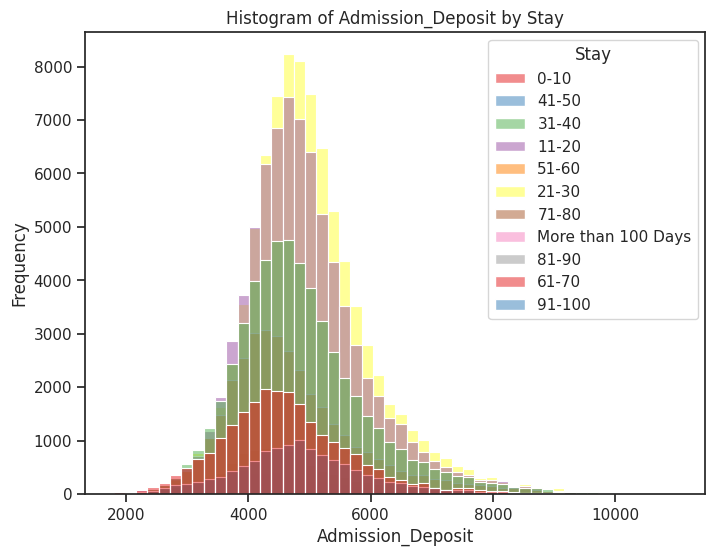

In [15]:
# Гістограми для числових ознак
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df, x=feature, hue='Stay', bins=50, kde=False, palette='Set1')
    plt.title(f'Histogram of {feature} by Stay')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

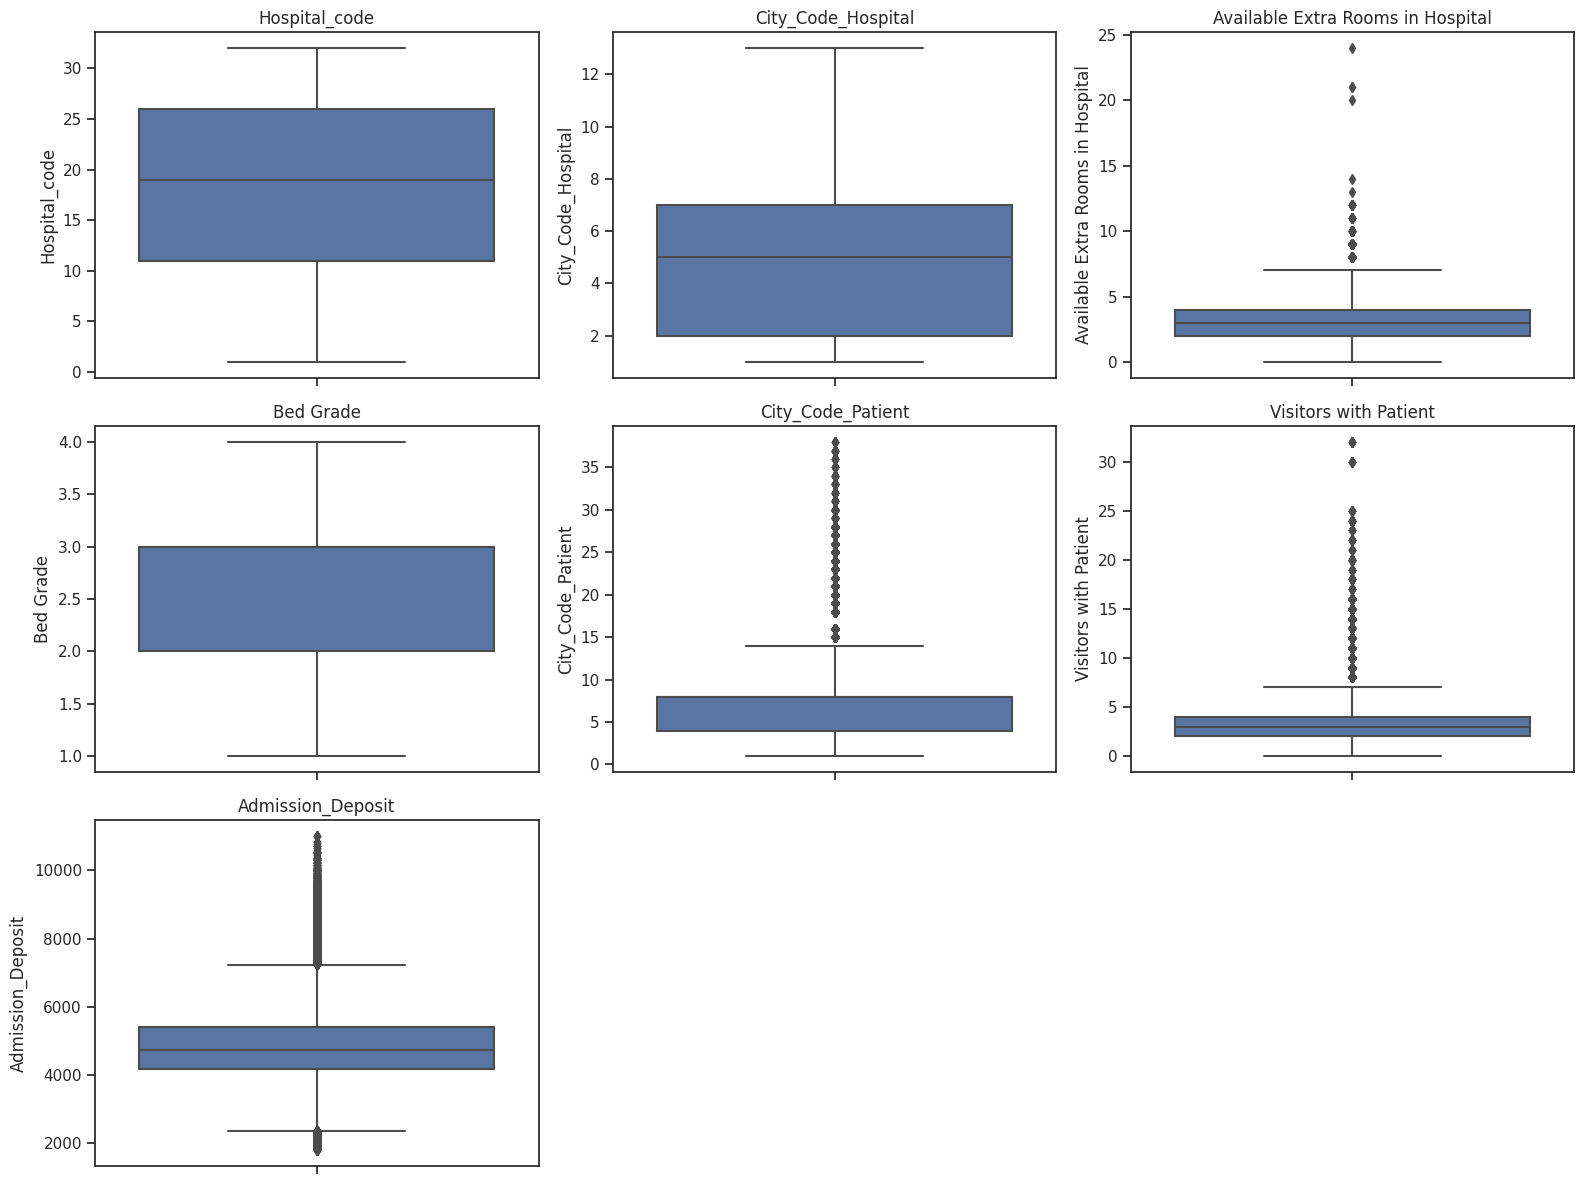

In [16]:
# Ящики з вусами для чилових ознак
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

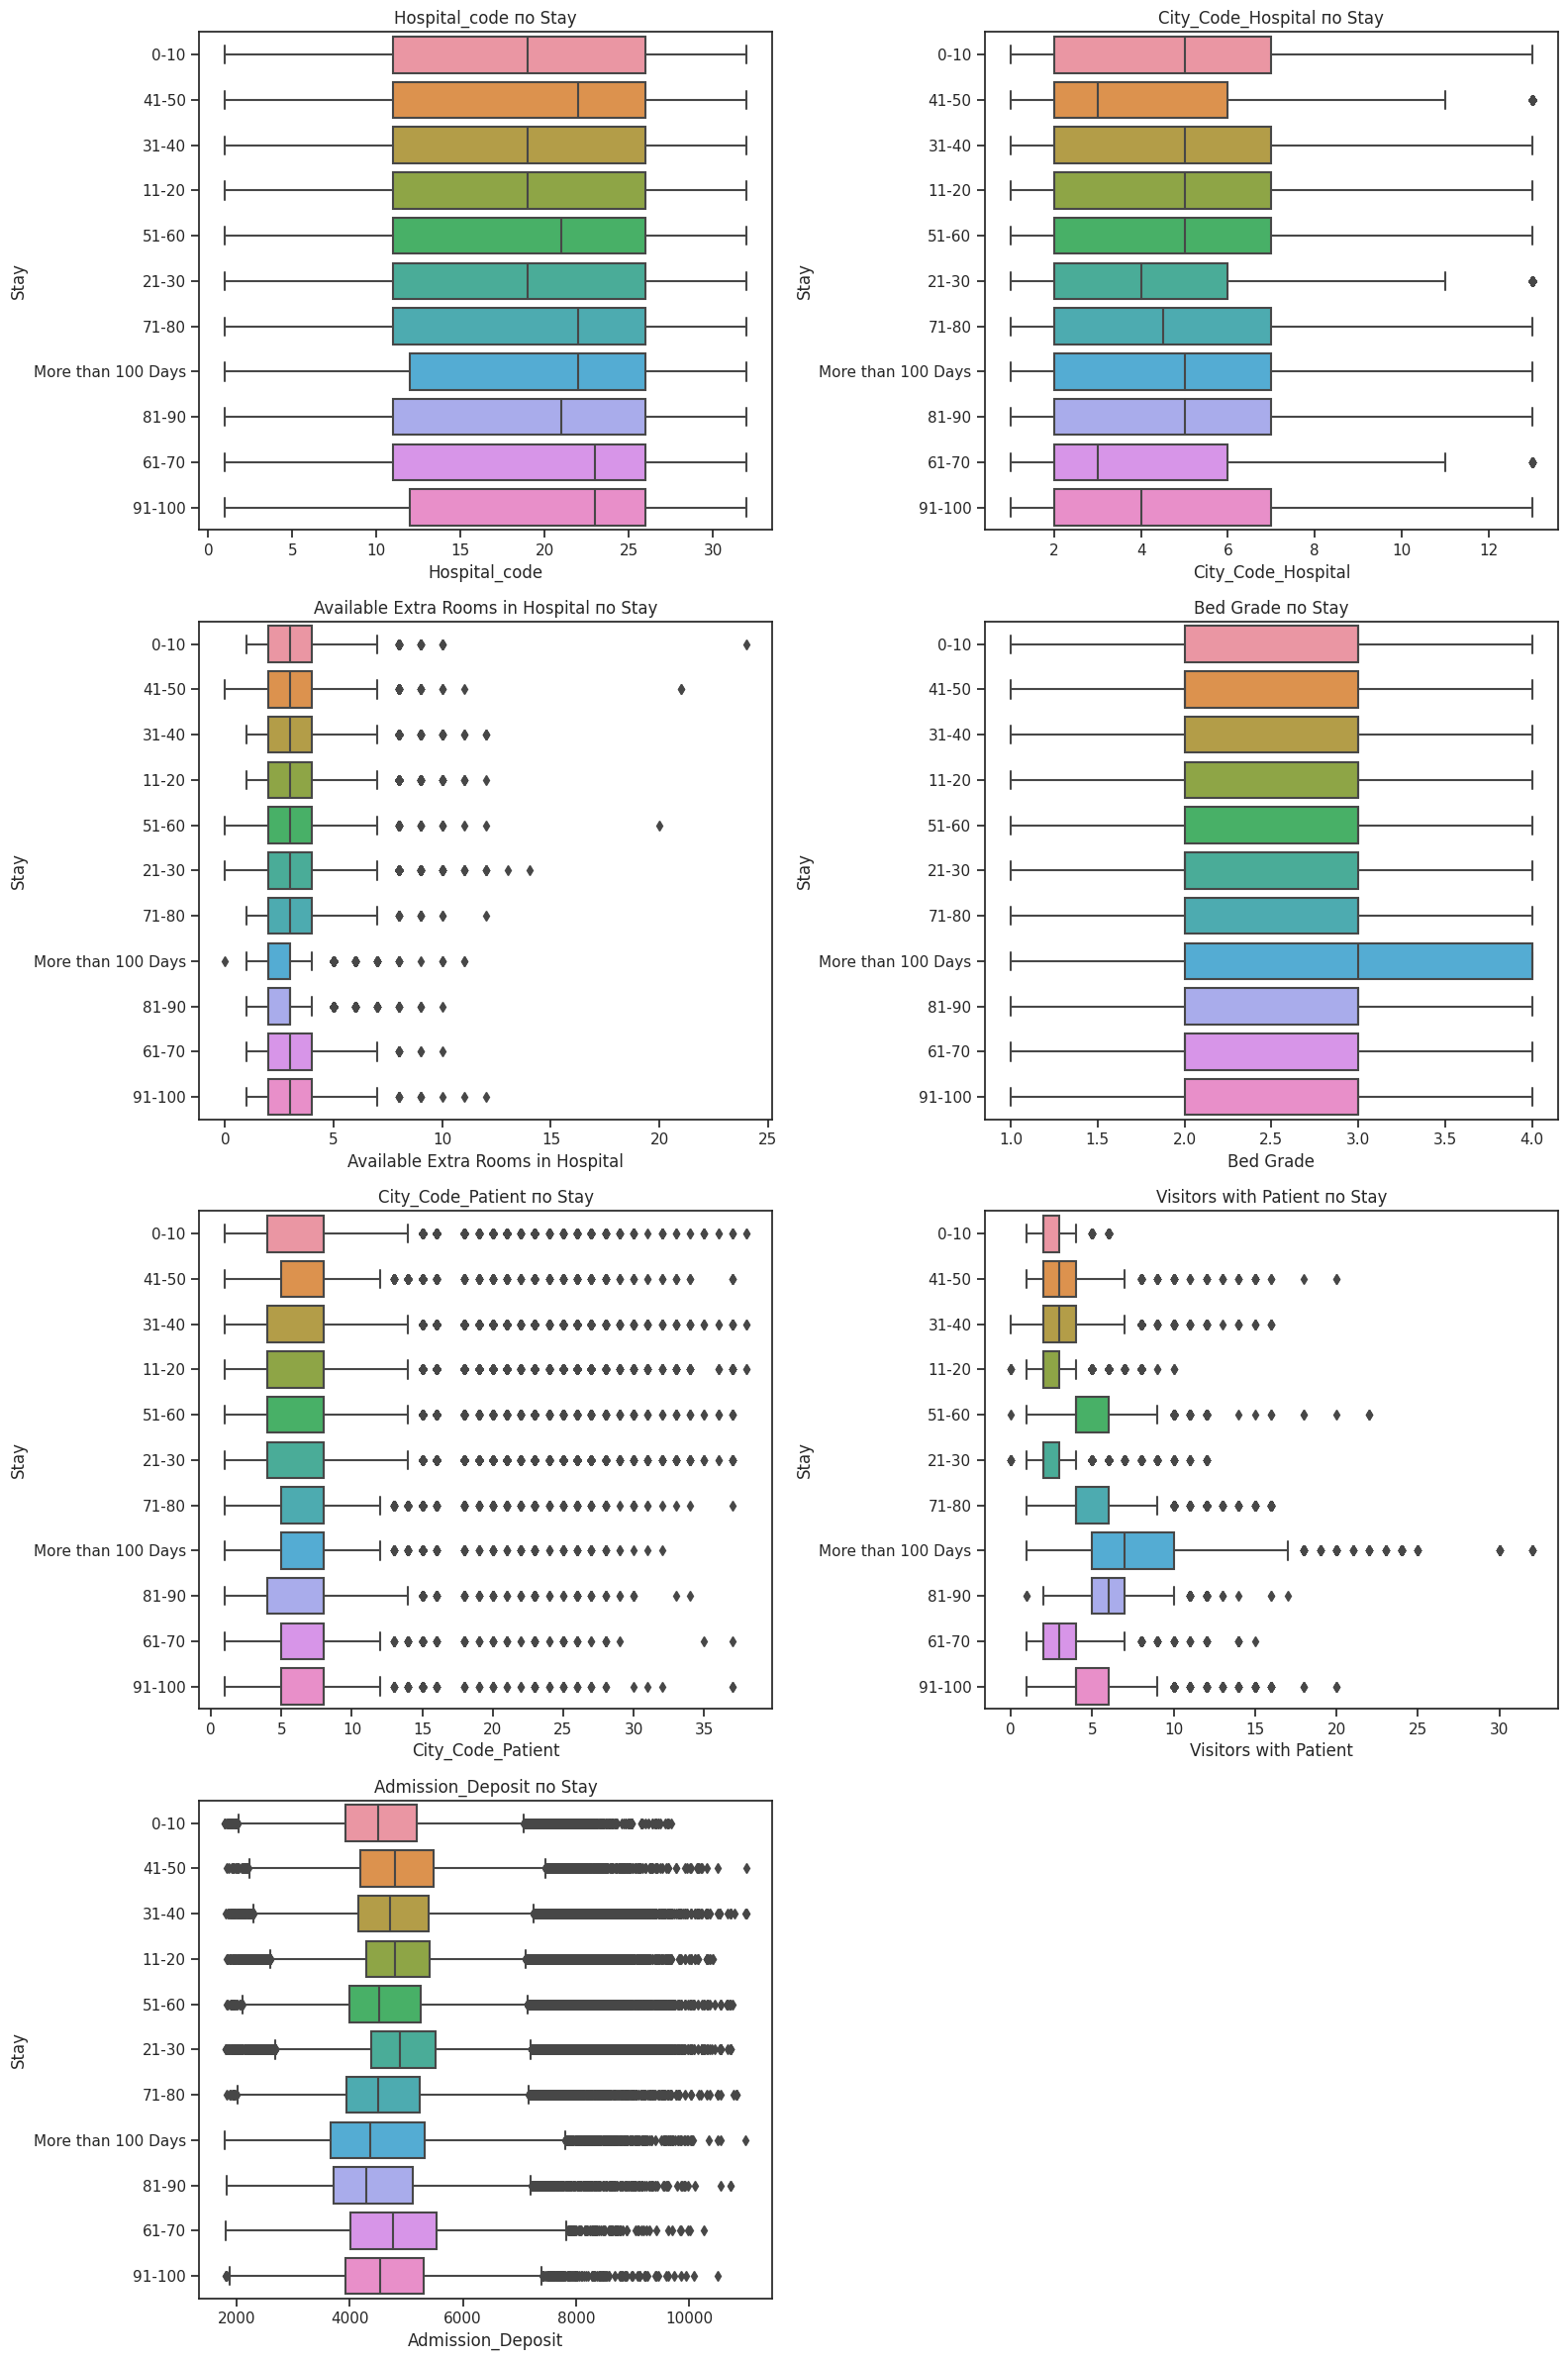

In [17]:
n_features = len(numeric_features)
n_cols = 2  
n_rows = int(np.ceil(n_features / n_cols))  

plt.figure(figsize=(n_cols * 8, n_rows * 6))

for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=feature, y='Stay', data=df)
    plt.title(f'{feature} по Stay')
    plt.xlabel(feature)
    plt.ylabel('Stay')

plt.tight_layout()
plt.show()

In [18]:
def remove_outliers(df, columns):
    print("Original shape: ", df.shape)
    for column_name in columns:
        q1 = df[column_name].quantile(q=0.25)
        q3 = df[column_name].quantile(q=0.75)

        IQR = q3 - q1
        lower = q1 - 1.5*IQR
        upper = q3 + 1.5*IQR

        mask = (df[column_name] >= lower) & (df[column_name] <= upper)
    return df[mask]


df = df.copy()
columns_with_otliers = ['City_Code_Patient', 'Admission_Deposit']
df = remove_outliers(df, columns_with_otliers)

print("Sales shape after remove values: ", df.shape)

Original shape:  (317350, 17)
Sales shape after remove values:  (305087, 17)


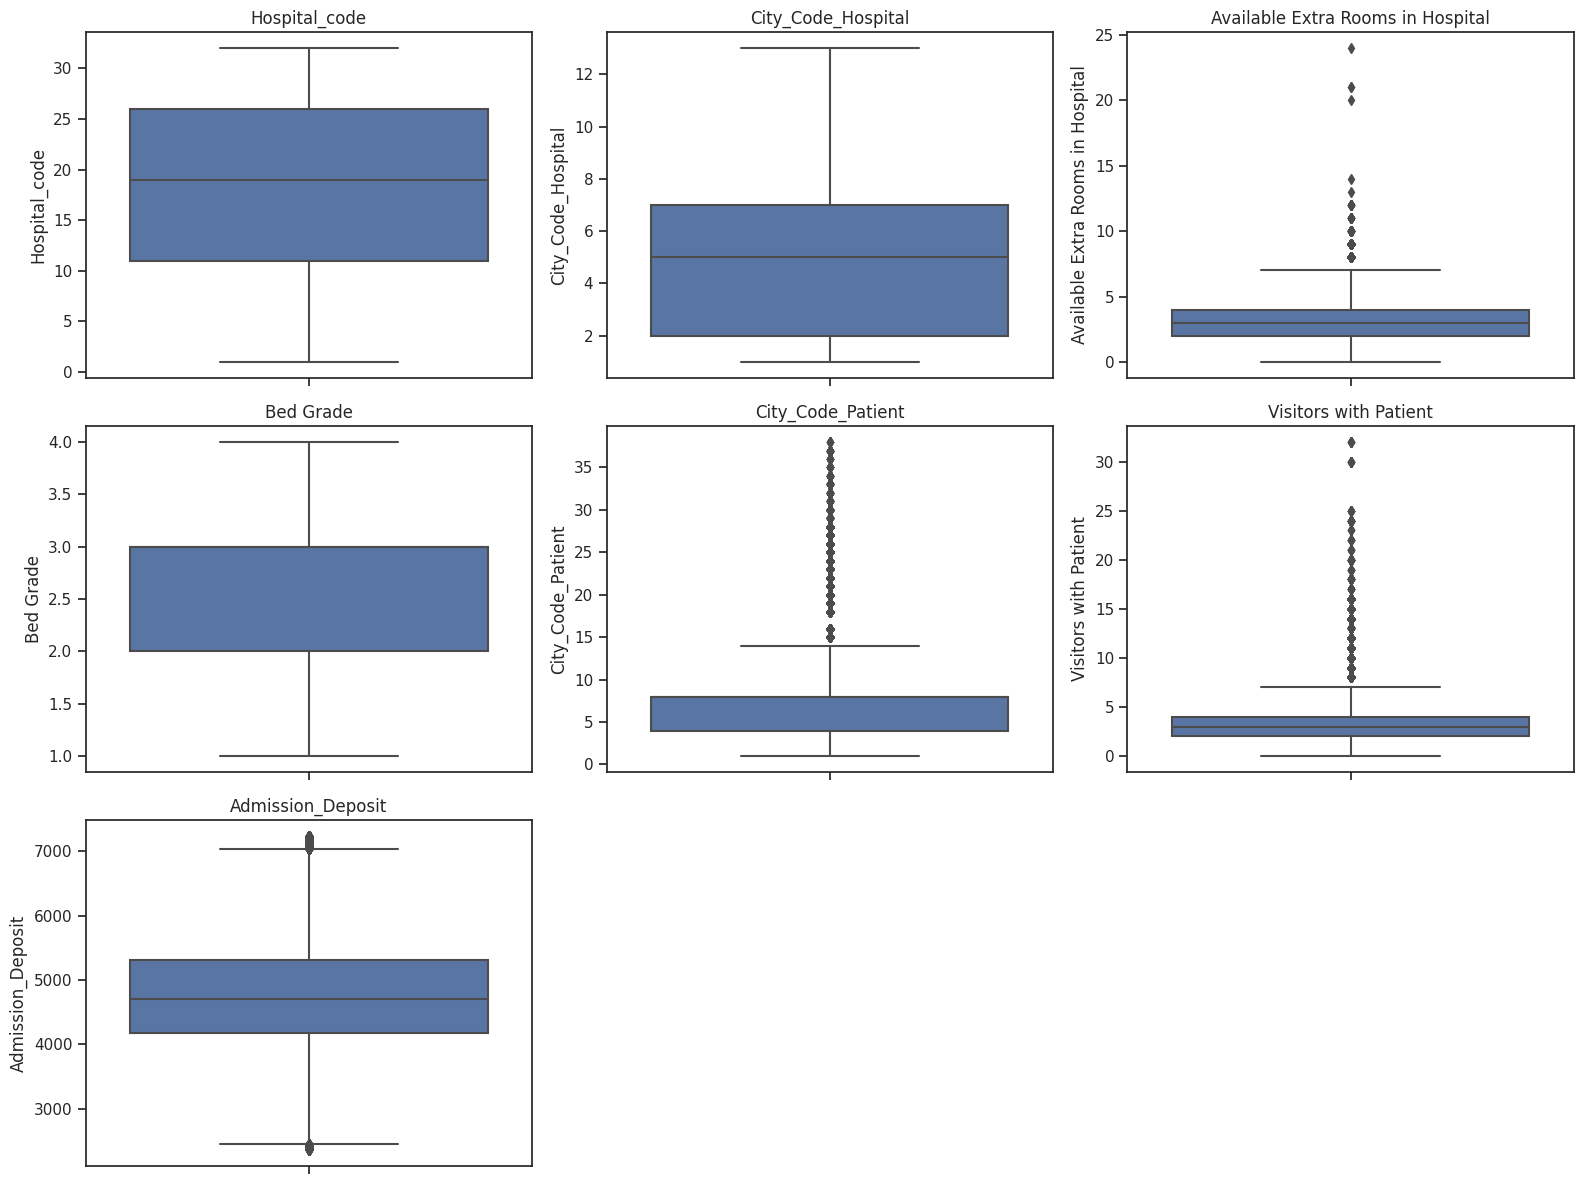

In [19]:
# Ящики з вусами для чилових ознак
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [21]:
df = df[df['City_Code_Patient'] < 20]
df.shape

(290009, 17)

In [25]:
df = df[df['Visitors with Patient'] < 21]
df.shape

(289911, 17)

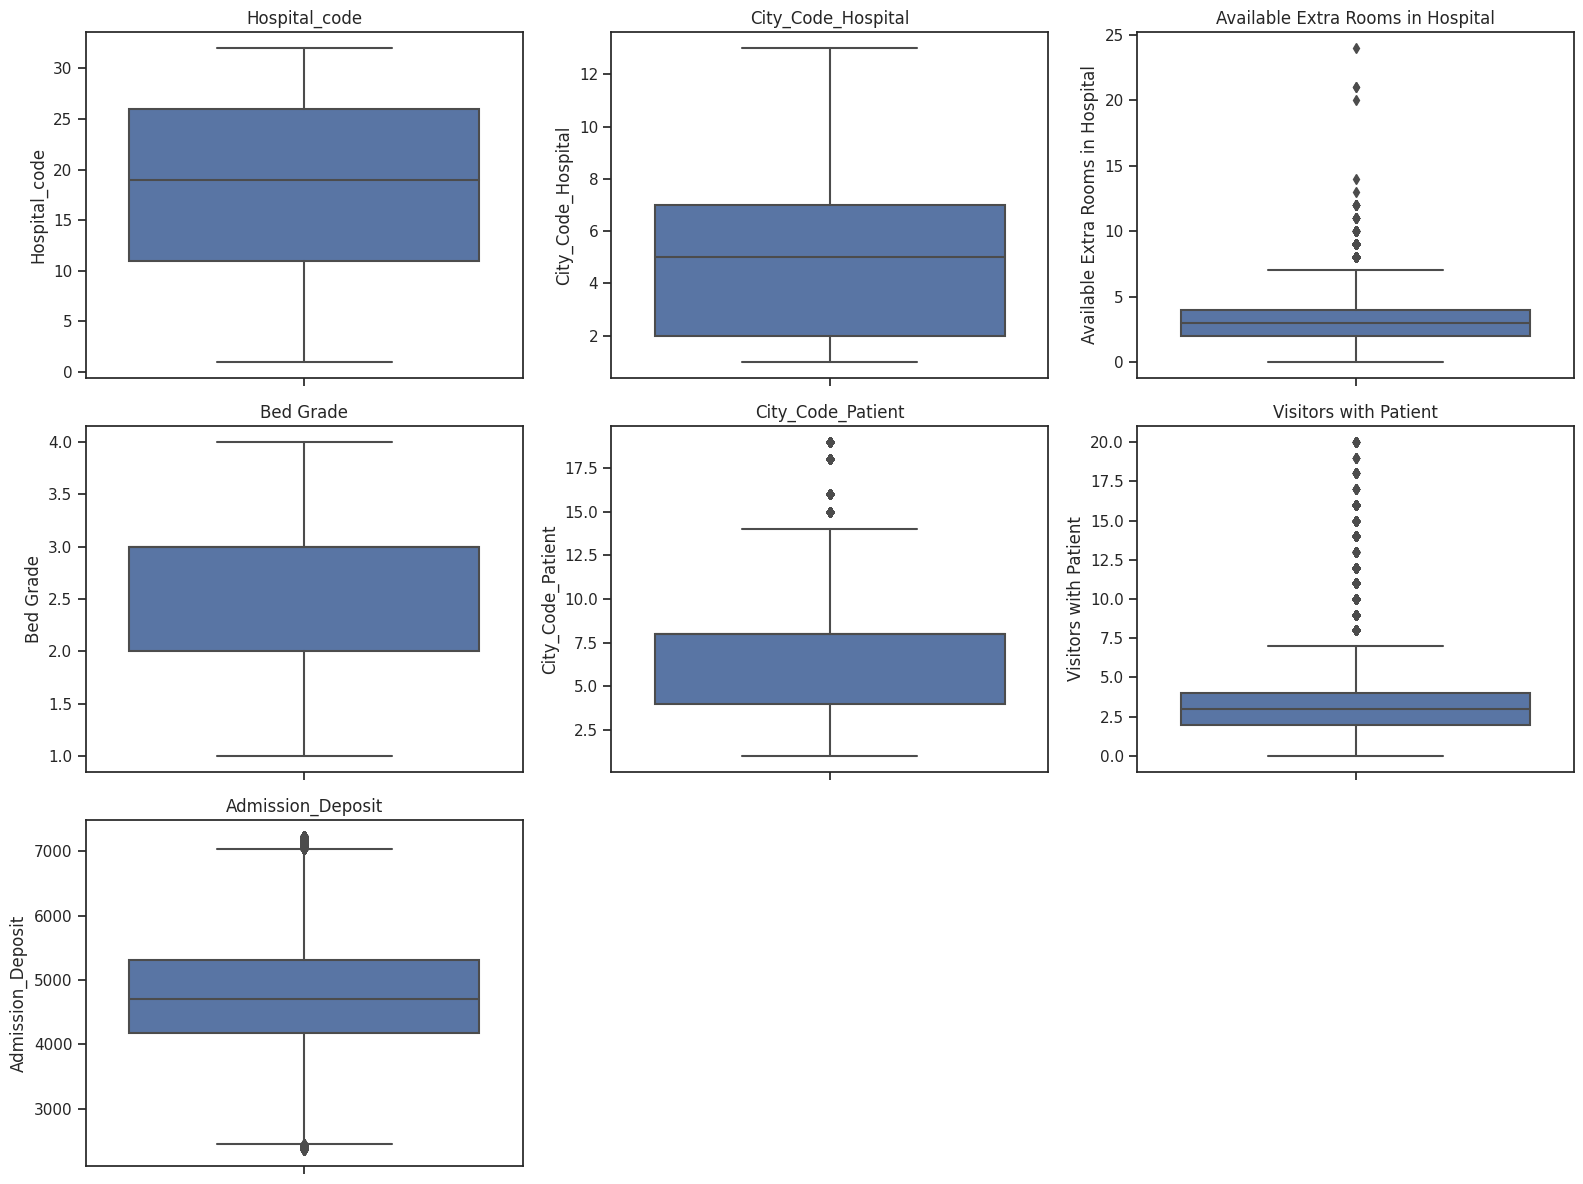

In [26]:
# Ящики з вусами для чилових ознак
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [27]:
categorical_columns = ['Hospital_code', 'City_Code_Hospital', 'Bed Grade','City_Code_Patient']
df[categorical_columns] = df[categorical_columns].astype('category')

In [28]:
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype('category')

In [29]:
categorical_features = df.select_dtypes(include=['category']).columns.tolist()

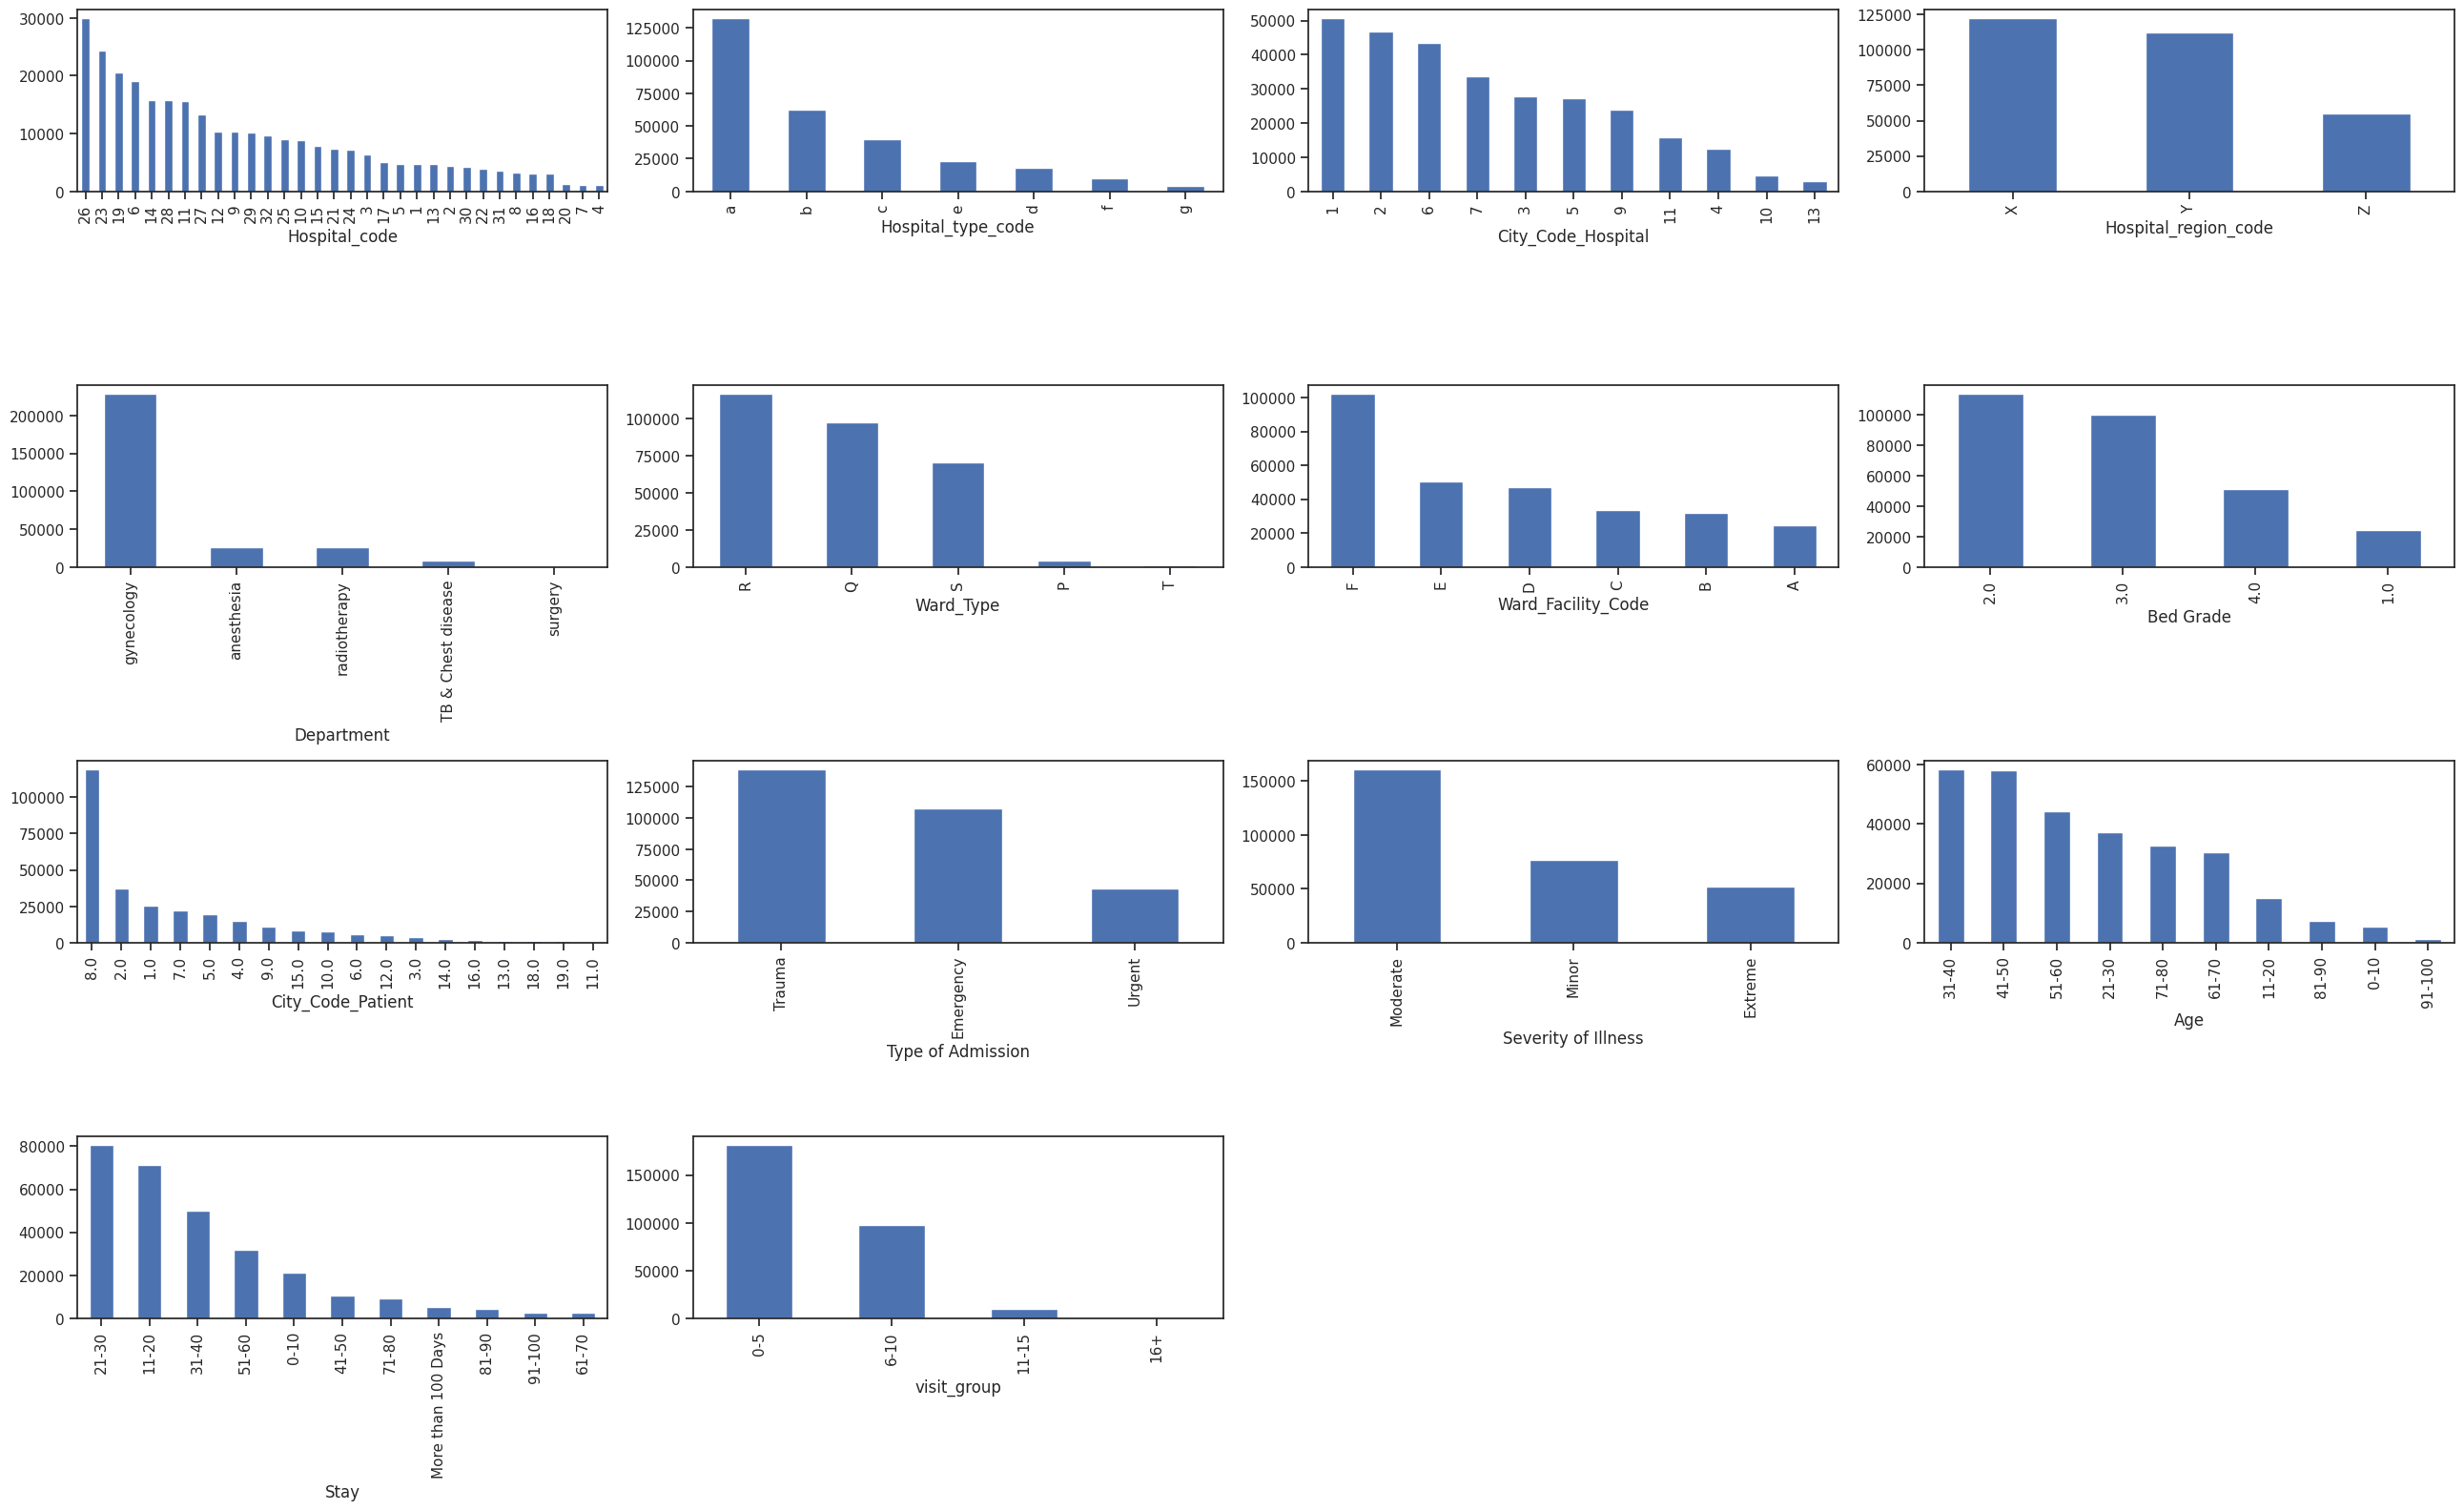

In [30]:
plt.figure(figsize=(26, 16))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i)
    df[feature].value_counts().plot(kind='bar')
plt.tight_layout()
plt.show()

In [31]:
mode_value = df['Bed Grade'].mode()[0]
df['Bed Grade'].fillna(mode_value, inplace=True)

In [32]:
y = df['Stay']
X = df.drop(columns=['Stay'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [89]:
class_counts = df['Stay'].value_counts()

In [88]:
class_weights = {class_label: total_samples / (len(class_counts) * count) for class_label, count in class_counts.items()}

In [90]:
class_weights

{'21-30': 0.3276463587879692,
 '11-20': 0.3689495961943256,
 '31-40': 0.524384111710017,
 '51-60': 0.8281396843533528,
 '0-10': 1.2345674280750165,
 '41-50': 2.4744667594165293,
 '71-80': 2.8489401637169447,
 'More than 100 Days': 4.790175473381581,
 '81-90': 6.152088107970461,
 '91-100': 10.640107167761588,
 '61-70': 10.80145305514158}

In [34]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include=['category','object']).columns

In [35]:
numeric_transformer_for_sgd = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

numeric_transformer_for_lgbm = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [36]:
preprocessor_sgd = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_for_sgd, num_columns),
        ('cat', categorical_transformer, cat_columns)])

preprocessor_lgbm = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_for_lgbm, num_columns),
        ('cat', categorical_transformer, cat_columns)])

In [37]:
X_train_preprocessed_sgd = preprocessor_sgd.fit_transform(X_train)
X_test_preprocessed_sgd = preprocessor_sgd.transform(X_test)

X_train_preprocessed_lgbm = preprocessor_lgbm.fit_transform(X_train)
X_test_preprocessed_lgbm = preprocessor_lgbm.transform(X_test)

In [91]:
def objective(trial):
    model_name = trial.suggest_categorical('model', [
        'LightGBM', 'DecisionTree', 'LogisticRegression', 'SGD'
    ])
    
    if model_name == 'LightGBM':
        params = {
            'objective': 'multiclass',
            'num_class': 11,
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 10, 50),
            'learning_rate': trial.suggest_float('gbm_learning_rate', 1e-3, 1e-1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 20, 250),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e-1),
            'force_col_wise': True
        }
        
        if params['boosting_type'] == 'dart':
            params.update({
                'max_drop': trial.suggest_int('max_drop', 0, 50),
                'drop_rate': trial.suggest_float('drop_rate', 0.1, 0.5),
                'skip_drop': trial.suggest_float('skip_drop', 0.0, 0.5)
            })

        model = lgb.LGBMClassifier(**params)
        
    elif model_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth', 5, 40)
        min_samples_split = trial.suggest_int('min_samples_split', 10, 100)
        class_weight = trial.suggest_categorical('class_weight', [class_weights, 'balanced'])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 20, 80)
        max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
        splitter = trial.suggest_categorical('splitter', ['best', 'random'])
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,class_weight=class_weight)
    
    elif model_name == 'LogisticRegression':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
        multi_class = 'multinomial'
        class_weight = trial.suggest_categorical('class_weight', [class_weights, 'balanced'])
        model = LogisticRegression(C=C, solver=solver, multi_class=multi_class, max_iter=1000, class_weight=class_weight)
        
        
    elif model_name == 'SGD':
        alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
        learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'adaptive'])
        if learning_rate in ['constant', 'invscaling','adaptive']:
            eta0 = trial.suggest_float('eta0', 1e-5, 1e-1, log=True)
        else:
            eta0 = 0.0
        loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
        class_weight = trial.suggest_categorical('class_weight', [class_weights, 'balanced'])
        model = SGDClassifier(alpha=alpha, loss=loss, learning_rate=learning_rate, eta0 = eta0, class_weight=class_weight)
        
        
    if model_name in ['SGD', 'LogisticRegression']:
        model.fit(X_train_preprocessed_sgd, y_train)
        y_pred = model.predict(X_test_preprocessed_sgd)
    elif model_name == 'LightGBM':
        model.fit(X_train_preprocessed_sgd, y_train)
        y_pred = model.predict(X_test_preprocessed_sgd)
    else:
        model.fit(X_train_preprocessed_sgd, y_train)
        y_pred = model.predict(X_test_preprocessed_sgd)
        
    f1_score = f1(y_test, y_pred, average='weighted')
    
    return f1_score

In [92]:
# Оптимізація гіперпараметрів
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print(f"Best trial: {study.best_trial.params}")
print(f"Best value: {study.best_value}")

best_params = study.best_trial.params
model_name = best_params.pop('model')

if model_name == 'LightGBM':
    model = lgb.LGBMClassifier(**best_params)
elif model_name == 'DecisionTree':
    model = DecisionTreeClassifier(**best_params)
elif model_name == 'LogisticRegression':
    model = LogisticRegression(**best_params)
elif model_name == 'SGD':
    model = SGDClassifier(**best_params)

if model_name in ['SGD', 'LogisticRegression']:
    model.fit(X_train_preprocessed_sgd, y_train)
    y_pred = model.predict(X_test_preprocessed_sgd)
elif model_name == 'LightGBM':
        model.fit(X_train_preprocessed_sgd, y_train)
        y_pred = model.predict(X_test_preprocessed_sgd)
else:
    model.fit(X_train_preprocessed_sgd, y_train)
    y_pred = model.predict(X_test_preprocessed_sgd)


print(f"{model_name} F1 score with Best Parameters: {f1(y_test, y_pred, average='weighted')}")
print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}")

[I 2024-09-05 12:02:06,402] A new study created in memory with name: no-name-aaf74437-b34b-4499-ba2f-2e6b4685e2a5


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:02:24,721] Trial 0 finished with value: 0.12288829543691027 and parameters: {'model': 'LightGBM', 'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': 21, 'gbm_learning_rate': 0.0016719345350705947, 'n_estimators': 53, 'subsample': 0.7216233417101454, 'colsample_bytree': 0.9629161544472761, 'min_child_samples': 33, 'min_child_weight': 0.032914480211395064}. Best is trial 0 with value: 0.12288829543691027.
[I 2024-09-05 12:02:30,110] Trial 1 finished with value: 0.309510573499012 and parameters: {'model': 'SGD', 'alpha': 0.037794857958802525, 'learning_rate': 'optimal', 'loss': 'log_loss', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.309510573499012.
[I 2024-09-05 12:02:37,130] Trial 2 finished with value: 0.28537485728094514 and parameters: {'model': 'SGD', 'alpha': 0.0019053980998967892, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'class_weight': {'21-30': 0.3276463587879692, '11-20': 0.3689495961943256, '31-40': 0.524384111710017, '51-60': 

[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:02:57,259] Trial 3 finished with value: 0.1969320869658648 and parameters: {'model': 'LightGBM', 'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 28, 'gbm_learning_rate': 0.003933004779433668, 'n_estimators': 44, 'subsample': 0.5822731523784181, 'colsample_bytree': 0.8452059951739211, 'min_child_samples': 78, 'min_child_weight': 0.09083888063057505}. Best is trial 1 with value: 0.309510573499012.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:03:45,282] Trial 4 finished with value: 0.3563894003464449 and parameters: {'model': 'LightGBM', 'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 47, 'gbm_learning_rate': 0.0046174010261609885, 'n_estimators': 111, 'subsample': 0.8395539089767541, 'colsample_bytree': 0.7866411055639126, 'min_child_samples': 40, 'min_child_weight': 0.07846558502943686}. Best is trial 4 with value: 0.3563894003464449.
[I 2024-09-05 12:04:17,983] Trial 5 finished with value: 0.28575412319145155 and parameters: {'model': 'LogisticRegression', 'C': 14.306744983835781, 'solver': 'lbfgs', 'class_weight': 'balanced'}. Best is trial 4 with value: 0.3563894003464449.
[I 2024-09-05 12:04:45,996] Trial 6 finished with value: 0.29619437377487123 and parameters: {'model': 'SGD', 'alpha': 0.0001738054182845576, 'learning_rate': 'adaptive', 'eta0': 0.02122545325828867, 'loss': 'modified_huber', 'class_weight': {'21-30': 0.3276463587879692, '11-20': 0.3689495961943256, '31-40': 0.524384111710017

[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:20:29,075] Trial 10 finished with value: 0.3889487172564349 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': 48, 'gbm_learning_rate': 0.04995077717571872, 'n_estimators': 218, 'subsample': 0.9140759423814138, 'colsample_bytree': 0.5710359421301472, 'min_child_samples': 38, 'min_child_weight': 0.08783661787175771, 'max_drop': 33, 'drop_rate': 0.34886405687326305, 'skip_drop': 0.44880231456191405}. Best is trial 10 with value: 0.3889487172564349.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:40:55,949] Trial 11 finished with value: 0.3924198684302317 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': 50, 'gbm_learning_rate': 0.07105041994809341, 'n_estimators': 249, 'subsample': 0.9687880335399757, 'colsample_bytree': 0.5195675145995312, 'min_child_samples': 38, 'min_child_weight': 0.08788649616081406, 'max_drop': 34, 'drop_rate': 0.35841849857730185, 'skip_drop': 0.48416289111122757}. Best is trial 11 with value: 0.3924198684302317.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 12:59:03,042] Trial 12 finished with value: 0.39436321107560435 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 50, 'gbm_learning_rate': 0.0864704417472029, 'n_estimators': 250, 'subsample': 0.9416450334079952, 'colsample_bytree': 0.5040023804222729, 'min_child_samples': 47, 'min_child_weight': 0.07189890899865065, 'max_drop': 36, 'drop_rate': 0.35576052856476303, 'skip_drop': 0.4606814288253212}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 13:17:01,524] Trial 13 finished with value: 0.3925329047029123 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 39, 'gbm_learning_rate': 0.09332590863683654, 'n_estimators': 241, 'subsample': 0.9898772758596361, 'colsample_bytree': 0.5008757068466305, 'min_child_samples': 58, 'min_child_weight': 0.05933760568539686, 'max_drop': 37, 'drop_rate': 0.3660147568555675, 'skip_drop': 0.4897790921561224}. Best is trial 12 with value: 0.39436321107560435.
[I 2024-09-05 13:17:33,560] Trial 14 finished with value: 0.23959253115026644 and parameters: {'model': 'DecisionTree', 'max_depth': 33, 'min_samples_split': 99, 'class_weight': {'21-30': 0.3276463587879692, '11-20': 0.3689495961943256, '31-40': 0.524384111710017, '51-60': 0.8281396843533528, '0-10': 1.2345674280750165, '41-50': 2.4744667594165293, '71-80': 2.8489401637169447, 'More than 100 Days': 4.790175473381581, '81-90': 6.152088107970461, '91-100': 10.640107167761588, '61-70': 10

[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 13:32:49,626] Trial 15 finished with value: 0.3836796637201772 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 40, 'max_depth': 39, 'gbm_learning_rate': 0.03001190826875369, 'n_estimators': 189, 'subsample': 0.9913610432634585, 'colsample_bytree': 0.621582629259251, 'min_child_samples': 66, 'min_child_weight': 0.050207367101808925, 'max_drop': 50, 'drop_rate': 0.49221688245700485, 'skip_drop': 0.49894912548030584}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 13:36:17,603] Trial 16 finished with value: 0.3767913274687003 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 40, 'gbm_learning_rate': 0.01840321999589276, 'n_estimators': 166, 'subsample': 0.8056876291934065, 'colsample_bytree': 0.640214793264519, 'min_child_samples': 58, 'min_child_weight': 0.05753218776520612, 'max_drop': 6, 'drop_rate': 0.10747830013250145, 'skip_drop': 0.21931501781896073}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 14:08:01,243] Trial 17 finished with value: 0.3721861835555267 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 40, 'gbm_learning_rate': 0.09584275428896814, 'n_estimators': 248, 'subsample': 0.878605594501608, 'colsample_bytree': 0.5059990079024188, 'min_child_samples': 97, 'min_child_weight': 0.0028976957852773766, 'max_drop': 43, 'drop_rate': 0.3149622263432391, 'skip_drop': 0.01518051275393878}. Best is trial 12 with value: 0.39436321107560435.
[I 2024-09-05 14:09:18,364] Trial 18 finished with value: 0.2789391910621999 and parameters: {'model': 'LogisticRegression', 'C': 0.0011532018634087475, 'solver': 'saga', 'class_weight': {'21-30': 0.3276463587879692, '11-20': 0.3689495961943256, '31-40': 0.524384111710017, '51-60': 0.8281396843533528, '0-10': 1.2345674280750165, '41-50': 2.4744667594165293, '71-80': 2.8489401637169447, 'More than 100 Days': 4.790175473381581, '81-90': 6.152088107970461, '91-100': 10.640107167761588, 

[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 14:14:38,170] Trial 20 finished with value: 0.3695120913002052 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 25, 'max_depth': 43, 'gbm_learning_rate': 0.017664656179916936, 'n_estimators': 132, 'subsample': 0.701069341788708, 'colsample_bytree': 0.6902518751635954, 'min_child_samples': 57, 'min_child_weight': 0.06250621941749604, 'max_drop': 20, 'drop_rate': 0.44291508576180627, 'skip_drop': 0.3354788434916689}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 14:31:49,729] Trial 21 finished with value: 0.39368189798095543 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 60, 'max_depth': 50, 'gbm_learning_rate': 0.09143818600506542, 'n_estimators': 242, 'subsample': 0.9856115427934201, 'colsample_bytree': 0.5003043721401079, 'min_child_samples': 44, 'min_child_weight': 0.07110477187576104, 'max_drop': 32, 'drop_rate': 0.3650215723674877, 'skip_drop': 0.49906402804636785}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 14:47:38,356] Trial 22 finished with value: 0.3896478842958988 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 50, 'gbm_learning_rate': 0.09673621748578395, 'n_estimators': 217, 'subsample': 0.9560456163236692, 'colsample_bytree': 0.500036067580746, 'min_child_samples': 50, 'min_child_weight': 0.06808983408567854, 'max_drop': 31, 'drop_rate': 0.397409765496035, 'skip_drop': 0.38199067355365696}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 15:02:02,900] Trial 23 finished with value: 0.38887580724097365 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 76, 'max_depth': 33, 'gbm_learning_rate': 0.04062537225982228, 'n_estimators': 216, 'subsample': 0.9995035520774151, 'colsample_bytree': 0.5870007221457214, 'min_child_samples': 26, 'min_child_weight': 0.04101898229388792, 'max_drop': 39, 'drop_rate': 0.2250451869396875, 'skip_drop': 0.3815233232641594}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 15:18:42,220] Trial 24 finished with value: 0.38854991811388107 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 44, 'gbm_learning_rate': 0.0474647103681515, 'n_estimators': 241, 'subsample': 0.9192450278439104, 'colsample_bytree': 0.5683388464046218, 'min_child_samples': 49, 'min_child_weight': 0.07483022857993514, 'max_drop': 24, 'drop_rate': 0.26856407930275605, 'skip_drop': 0.4759962750199024}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 15:36:24,297] Trial 25 finished with value: 0.38714935269337747 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 45, 'gbm_learning_rate': 0.09729835802376748, 'n_estimators': 188, 'subsample': 0.8804740274312313, 'colsample_bytree': 0.7068165196165607, 'min_child_samples': 71, 'min_child_weight': 0.04852821533174464, 'max_drop': 42, 'drop_rate': 0.4232704060552523, 'skip_drop': 0.2065937081755341}. Best is trial 12 with value: 0.39436321107560435.


[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 15:46:51,589] Trial 26 finished with value: 0.384340799820132 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 36, 'gbm_learning_rate': 0.05213388486827868, 'n_estimators': 192, 'subsample': 0.7894885436212536, 'colsample_bytree': 0.5489168783829846, 'min_child_samples': 48, 'min_child_weight': 0.0719201288622135, 'max_drop': 27, 'drop_rate': 0.2733784015045511, 'skip_drop': 0.40384242569628376}. Best is trial 12 with value: 0.39436321107560435.
[I 2024-09-05 15:47:24,251] Trial 27 finished with value: 0.2849733479762714 and parameters: {'model': 'LogisticRegression', 'C': 805.4137615758272, 'solver': 'lbfgs', 'class_weight': {'21-30': 0.3276463587879692, '11-20': 0.3689495961943256, '31-40': 0.524384111710017, '51-60': 0.8281396843533528, '0-10': 1.2345674280750165, '41-50': 2.4744667594165293, '71-80': 2.8489401637169447, 'More than 100 Days': 4.790175473381581, '81-90': 6.152088107970461, '91-100': 10.640107167761588, '61-70

[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


[I 2024-09-05 15:58:48,818] Trial 29 finished with value: 0.3815357344518319 and parameters: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 54, 'max_depth': 43, 'gbm_learning_rate': 0.023542828016031116, 'n_estimators': 224, 'subsample': 0.9351156829856219, 'colsample_bytree': 0.6358246569025491, 'min_child_samples': 20, 'min_child_weight': 0.02307687165427019, 'max_drop': 16, 'drop_rate': 0.37380417052123266, 'skip_drop': 0.31815323264309175}. Best is trial 12 with value: 0.39436321107560435.


Best trial: {'model': 'LightGBM', 'boosting_type': 'dart', 'num_leaves': 52, 'max_depth': 50, 'gbm_learning_rate': 0.0864704417472029, 'n_estimators': 250, 'subsample': 0.9416450334079952, 'colsample_bytree': 0.5040023804222729, 'min_child_samples': 47, 'min_child_weight': 0.07189890899865065, 'max_drop': 36, 'drop_rate': 0.35576052856476303, 'skip_drop': 0.4606814288253212}
Best value: 0.39436321107560435
[LightGBM] [Warning] Unknown parameter: gbm_learning_rate
[LightGBM] [Warning] Unknown parameter: gbm_learning_rate
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Star

In [93]:
best_params = study.best_trials[0].params
best_params

{'model': 'LightGBM',
 'boosting_type': 'dart',
 'num_leaves': 52,
 'max_depth': 50,
 'gbm_learning_rate': 0.0864704417472029,
 'n_estimators': 250,
 'subsample': 0.9416450334079952,
 'colsample_bytree': 0.5040023804222729,
 'min_child_samples': 47,
 'min_child_weight': 0.07189890899865065,
 'max_drop': 36,
 'drop_rate': 0.35576052856476303,
 'skip_drop': 0.4606814288253212}

In [97]:
params = {'boosting_type': 'dart',
 'num_leaves': 52,
 'max_depth': 50,
 'gbm_learning_rate': 0.0864704417472029,
 'n_estimators': 250,
 'subsample': 0.9416450334079952,
 'colsample_bytree': 0.5040023804222729,
 'min_child_samples': 47,
 'min_child_weight': 0.07189890899865065,
 'max_drop': 36,
 'drop_rate': 0.35576052856476303,
 'skip_drop': 0.4606814288253212}

In [98]:
model = lgb.LGBMClassifier(**params)

In [99]:
model.fit(X_train_preprocessed_sgd, y_train)

[LightGBM] [Warning] Unknown parameter: gbm_learning_rate
[LightGBM] [Warning] Unknown parameter: gbm_learning_rate
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 515
[LightGBM] [Info] Number of data points in the train set: 231928, number of used features: 114
[LightGBM] [Info] Start training from score -2.605596
[LightGBM] [Info] Start training from score -1.403411
[LightGBM] [Info] Start training from score -1.283023
[LightGBM] [Info] Start training from score -1.752112
[LightGBM] [Info] Start training from score -3.308245
[LightGBM] [Info] Start training from score -2.209358
[LightGBM] [Info] Start training from score -4.775525
[LightGBM] [Info] Start training from score -3.436738
[LightGBM] [Info] Start training from score -4.201696
[LightGBM] [Info] Start training from score -4.752780
[LightGBM] [Info] Start training from score -3.951502


LGBMClassifier(boosting_type='dart', colsample_bytree=0.5040023804222729,
               drop_rate=0.35576052856476303,
               gbm_learning_rate=0.0864704417472029, max_depth=50, max_drop=36,
               min_child_samples=47, min_child_weight=0.07189890899865065,
               n_estimators=250, num_leaves=52, skip_drop=0.4606814288253212,
               subsample=0.9416450334079952)

In [100]:
y_pred = model.predict(X_test_preprocessed_sgd)

[LightGBM] [Warning] Unknown parameter: gbm_learning_rate


In [101]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
                    precision    recall  f1-score   support

              0-10       0.42      0.15      0.22      4218
             11-20       0.44      0.50      0.47     14436
             21-30       0.43      0.68      0.52     16149
             31-40       0.45      0.23      0.30     10042
             41-50       0.00      0.00      0.00      2167
             51-60       0.41      0.51      0.45      6366
             61-70       0.00      0.00      0.00       484
             71-80       0.29      0.02      0.03      1790
             81-90       0.36      0.18      0.24       812
            91-100       0.27      0.01      0.01       476
More than 100 Days       0.51      0.41      0.45      1043

          accuracy                           0.43     57983
         macro avg       0.32      0.24      0.25     57983
      weighted avg       0.41      0.43      0.39     57983



In [104]:
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']